In [1]:
import numpy as np

In [2]:
from modules import experimental_data as expdata
import modules.experimental_rir as exprir
from modules import randomized_ir, utils, mcmc, adc
import modules.plots.experimental_data as exp_plots
import modules.plots.deconvolution as dec_plots

from modules_reloader import reloader
relmod = reloader(expdata, exp_plots, dec_plots, randomized_ir, utils, mcmc, adc, exprir)

In [3]:
relmod()

In [4]:
e = expdata.Event(10675)

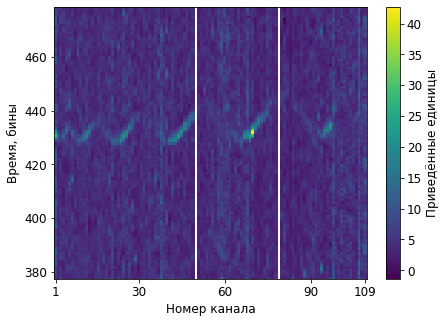

In [5]:
# filename = 'experimental-frame-example'
filename = None

f, a  = exp_plots.plot_signals_frame(e, units='scaled', filename=filename)

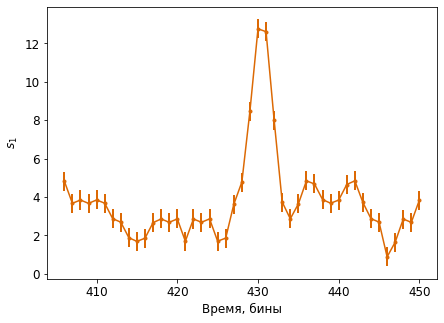

In [38]:
N = 45
i_ch = 1

s_vec_t, s_vec, adc_step = e.signal_in_channel(i_ch, window=N)

f, a = exp_plots.plot_signal_in_channel(e, i_ch, window=N)

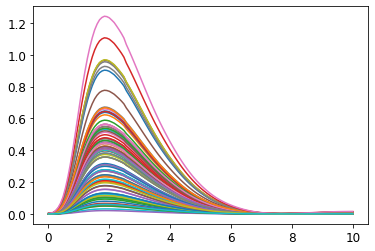

In [39]:
ham_rireff, feu84_rireff = exprir.get_rireffs(N)

rireff = feu84_rireff
L = rireff.L

rireff.rir.plot_realizations(count=100)

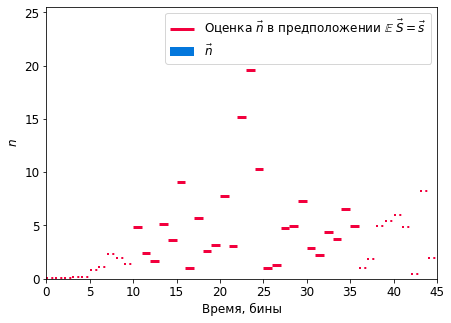

In [40]:
n_vec_estimation = rireff.estimate_n_vec(s_vec, delta=adc_step)
f, a = dec_plots.plot_mean_n_estimation(np.zeros_like(n_vec_estimation), n_vec_estimation, L)

In [10]:
ll_fact = rireff.get_loglikelihood_independent_normdist(s_vec, delta=adc_step, density=False)
ll_mvn = rireff.get_loglikelihood_mvn(s_vec, delta=adc_step, density=False)

In [12]:
ll_fact(n_vec_estimation)

-inf

In [19]:
result_preliminary = mcmc.run_mcmc(
    logposterior=ll_fact,
    init_point=n_vec_estimation,
    L=L,
    config=mcmc.SamplingConfig(
        n_walkers=256,
        n_samples=30000,
        progress_bar=True,
        # autocorr_estimation_each=3000,
        # debug_acceptance_fraction_each=500,
    ) 
)

  2%|▏         | 635/30000 [00:00<00:41, 705.76it/s]
 Current acc. frac.:0.0
  4%|▍         | 1130/30000 [00:01<00:41, 702.47it/s]
 Current acc. frac.:0.0
  5%|▌         | 1626/30000 [00:02<00:40, 704.45it/s]
 Current acc. frac.:0.0
  7%|▋         | 2122/30000 [00:03<00:39, 697.59it/s]
 Current acc. frac.:0.0
  9%|▊         | 2614/30000 [00:03<00:39, 691.77it/s]
 Current acc. frac.:0.0
 10%|█         | 3110/30000 [00:04<00:38, 703.03it/s]
 Current acc. frac.:0.0
 12%|█▏        | 3607/30000 [00:05<00:37, 702.87it/s]
 Current acc. frac.:0.0
 14%|█▎        | 4105/30000 [00:05<00:36, 708.13it/s]
 Current acc. frac.:0.0
 15%|█▌        | 4600/30000 [00:06<00:36, 697.15it/s]
 Current acc. frac.:0.0
 17%|█▋        | 5095/30000 [00:07<00:35, 702.32it/s]
 Current acc. frac.:0.0
 19%|█▊        | 5590/30000 [00:08<00:35, 695.36it/s]
 Current acc. frac.:0.0
 20%|██        | 6078/30000 [00:08<00:39, 604.82it/s]
 Current acc. frac.:0.0
 22%|██▏       | 6581/30000 [00:09<00:33, 703.33it/s]
 Current ac

In [38]:
n_walkers_final = 128

init_pts = mcmc.extract_independent_sample(result_preliminary.sampler, tau_override=tau, desired_sample_size=n_walkers_final)

In [39]:
result = mcmc.run_mcmc(
    logposterior=ll_mvn,
    init_point=init_pts,
    L=L,
    config=mcmc.SamplingConfig(
        n_walkers=n_walkers_final,
        n_samples=4 * tau,
        progress_bar=True,
        starting_points_strategy='given',
    )
)

100%|██████████| 4426/4426 [50:14<00:00,  1.47it/s]


In [40]:
sample_preliminary = mcmc.extract_independent_sample(result_preliminary.sampler, tau_override=tau, debug=True)
sample = mcmc.extract_independent_sample(result.sampler, tau_override=tau, debug=True)

Autocorrelation time is estimated at 1106.5266778600978 (ranges from 1106.5266778600978 to 1106.5266778600978)
Burn-in = 2213 samples
Thinning = 995 samples
Autocorrelation time is estimated at 1106.5266778600978 (ranges from 1106.5266778600978 to 1106.5266778600978)
Burn-in = 2213 samples
Thinning = 995 samples


/home/njvh/Documents/Science/sphere/thesis/modules/plots/deconvolution.py:233: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolormesh(


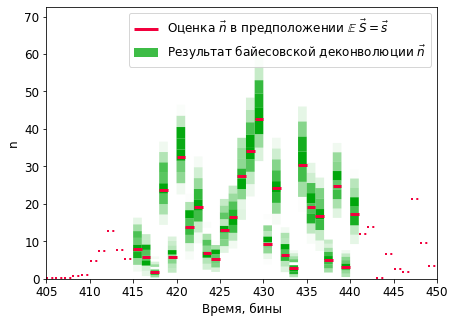

In [17]:
f, a = dec_plots.plot_bayesian_mean_estimation(None, sample_preliminary, L, n_vec_estimation, signal_t=s_vec_t)

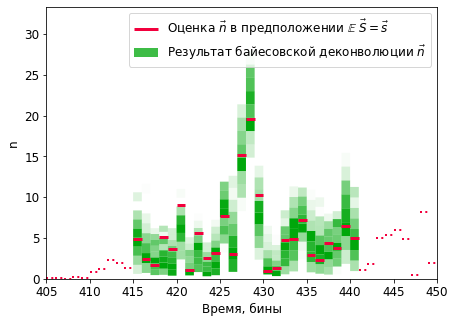

In [42]:
# filename = 'experimental-signal-deconvolution-example'
filename = None

f, a = dec_plots.plot_bayesian_mean_estimation(None, sample, L, n_vec_estimation, filename=filename, signal_t=s_vec_t)

In [44]:
np.save('../temp-data/deconvolution-results/10675.1.deconv-example', sample)